In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim


In [2]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset= torchvision.datasets.MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= torchvision.datasets.MNIST(root= './data', train= False, download= True, transform= transform)

train_loader= DataLoader(dataset= train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(dataset= test_dataset, batch_size= BATCH_SIZE, shuffle= False)

class_names= train_dataset.classes

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.65MB/s]


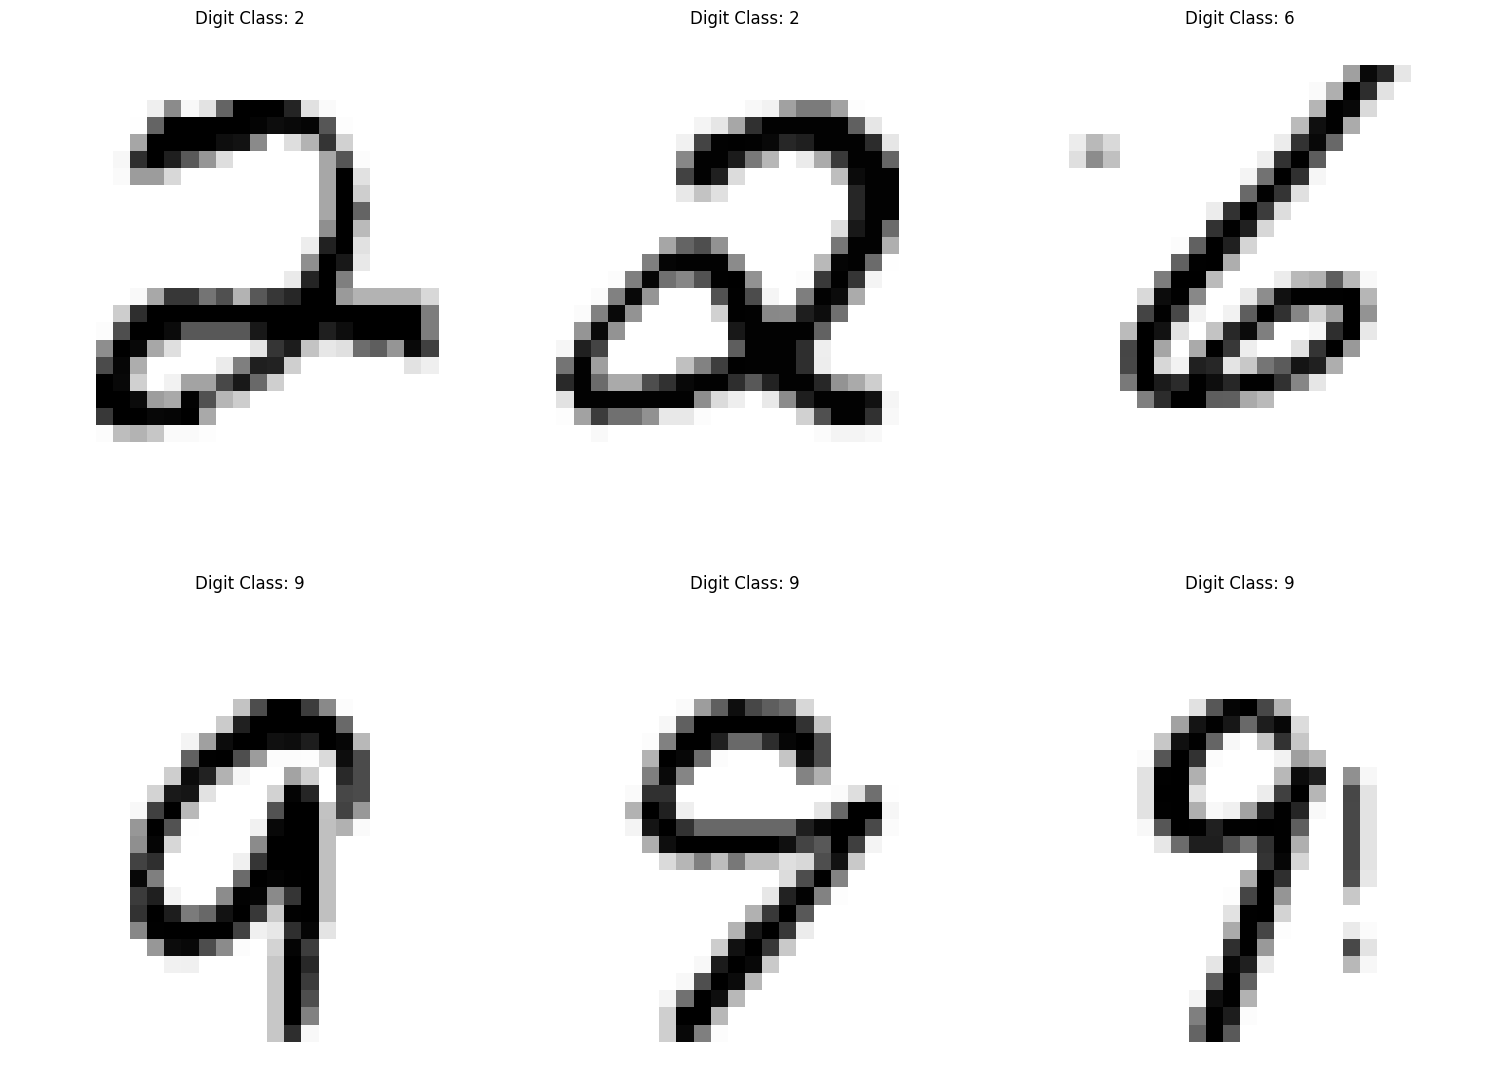

In [3]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [4]:
class PerceptronLayer(nn.Module):
    def __init__(self, in_features, out_features, bias= True):
        super(PerceptronLayer, self).__init__()
        self.linear= nn.Linear(in_features, out_features)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        output= self.linear(x)
        output= self.sigmoid(output)
        return output

In [5]:
class PerceptronLayerReLU(nn.Module):
  def __init__(self, in_features, out_features, bias= True):
        super(PerceptronLayerReLU, self).__init__()
        self.linear= nn.Linear(in_features, out_features)
        self.relu= nn.ReLU()

  def forward(self, x):
        output= self.linear(x)
        output= self.relu(output)
        return output

In [6]:
class SigmoidMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Input Layer
        self.input_layer= PerceptronLayer(784, 512)
        self.layer1= PerceptronLayer(512, 256)
        self.layer2= PerceptronLayer(256, 128)
        self.output_layer= PerceptronLayer(128, 10)

        # Initialize Weights
        self.apply(self._initialize_weights)

        # History tracking
        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients
        self._hooks= []

    def _initialize_weights(self, m):
        """Apply Xavier Init"""
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        # Flatten Input
        x= x.view(x.size(0), -1)
        # Feature Learning
        x= self.input_layer(x)
        x= self.layer1(x)
        x= self.layer2(x)
        output= self.output_layer(x)

        return output

    def register_std_hooks(self):
        # Clear any existing hooks to avoid duplicates
        self.remove_hooks()  # Remove previous hooks if any
        self._hooks = []  # Reset list
        self.activation_stds = {}
        self.gradient_stds = {}

        # Define the types of modules to track
        types_to_track = (nn.Sigmoid, nn.Linear)

        # Iterate over all modules in the model
        for name, module in self.named_modules():
            if isinstance(module, types_to_track):
                # Forward hook: capture output activations
                def forward_hook(module, input, output, name=name):
                    if output.numel() > 1:  # Avoid scalar tensors
                        std = torch.std(output.detach().view(-1)).item()
                        self.activation_stds[name] = std
                    else:
                        self.activation_stds[name] = 0.0

                # Backward hook: capture output gradients
                def backward_hook(module, grad_input, grad_output, name=name):
                    if grad_output[0] is not None and grad_output[0].numel() > 1:
                        std = torch.std(grad_output[0].detach().view(-1)).item()
                        self.gradient_stds[name] = std
                    else:
                        self.gradient_stds[name] = 0.0

                # Register hooks and store handles
                forward_handle = module.register_forward_hook(forward_hook)
                backward_handle = module.register_full_backward_hook(backward_hook)
                self._hooks.extend([forward_handle, backward_handle])

    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

    def remove_hooks(self):
        """Remove all registered hooks to avoid memory leaks."""
        for hook in self._hooks:
            hook.remove()
        self._hooks = []

In [7]:
class ReLUMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Input Layer
        self.input_layer= PerceptronLayerReLU(784, 512)
        self.layer1= PerceptronLayerReLU(512, 256)
        self.layer2= PerceptronLayerReLU(256, 128)
        self.output_layer= PerceptronLayerReLU(128, 10)

        # Initialize Weights
        self.apply(self._initialize_weights)

        # History tracking
        self.activation_std_history= [] # List of Dicts: [{'fc1': std, ....}, ...]
        self.gradient_std_history= [] # Same for gradients
        self._hooks= []

    def _initialize_weights(self, m):
        """Apply Xavier Init"""
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        # Flatten Input
        x= x.view(x.size(0), -1)
        # Feature Learning
        x= self.input_layer(x)
        x= self.layer1(x)
        x= self.layer2(x)
        output= self.output_layer(x)

        return output

    def register_std_hooks(self):
        # Clear any existing hooks to avoid duplicates
        self.remove_hooks()  # Remove previous hooks if any
        self._hooks = []  # Reset list
        self.activation_stds = {}
        self.gradient_stds = {}

        # Define the types of modules to track
        types_to_track = (nn.Sigmoid, nn.Linear)

        # Iterate over all modules in the model
        for name, module in self.named_modules():
            if isinstance(module, types_to_track):
                # Forward hook: capture output activations
                def forward_hook(module, input, output, name=name):
                    if output.numel() > 1:  # Avoid scalar tensors
                        std = torch.std(output.detach().view(-1)).item()
                        self.activation_stds[name] = std
                    else:
                        self.activation_stds[name] = 0.0

                # Backward hook: capture output gradients
                def backward_hook(module, grad_input, grad_output, name=name):
                    if grad_output[0] is not None and grad_output[0].numel() > 1:
                        std = torch.std(grad_output[0].detach().view(-1)).item()
                        self.gradient_stds[name] = std
                    else:
                        self.gradient_stds[name] = 0.0

                # Register hooks and store handles
                forward_handle = module.register_forward_hook(forward_hook)
                backward_handle = module.register_full_backward_hook(backward_hook)
                self._hooks.extend([forward_handle, backward_handle])

    def log_std_to_history(self):
        self.activation_std_history.append(self.activation_stds.copy())
        self.gradient_std_history.append(self.gradient_stds.copy())
        self.activation_stds = {}
        self.gradient_stds = {}

    def remove_hooks(self):
        """Remove all registered hooks to avoid memory leaks."""
        for hook in self._hooks:
            hook.remove()
        self._hooks = []

In [8]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     scheduler=None):
    # Logging and Early Stopping Vars
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    activation_std_history = []
    gradient_std_history = []
    patience = 3
    best_val_accuracy = 0.0
    epochs_with_no_improvement = 0
    min_delta = 0.1

    # Register hooks for tracking gradients and activations
    model.register_std_hooks()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward Pass + Loss Calc
            preds = model(images)
            loss = loss_fn(preds, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_train_loss += loss.item()

            # Calculate Training Accuracy
            _, predicted = torch.max(preds.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Log activation/gradient std
        model.log_std_to_history()
        activation_std_history.append(model.activation_std_history[-1])
        gradient_std_history.append(model.gradient_std_history[-1])

        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                loss = loss_fn(preds, labels)

                running_val_loss += loss.item()

                _, predicted = torch.max(preds.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average losses
        running_val_loss /= len(test_loader)
        running_train_loss /= len(train_loader)

        # Calculate accuracies
        train_acc = (train_correct / train_total) * 100
        val_acc = (val_correct / val_total) * 100

        # Early stopping logic
        if val_acc > best_val_accuracy + min_delta:
            best_val_accuracy = val_acc
            epochs_with_no_improvement = 0
        else:
            epochs_with_no_improvement += 1

        # Log history and print
        train_loss_history.append(running_train_loss)
        val_loss_history.append(running_val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("Activation STDs:", model.activation_std_history[-1])
        print("Gradient STDs:", model.gradient_std_history[-1])
        print("-" * 50)

        if epochs_with_no_improvement >= patience:
            print(f"Early Stopping Triggered at Epoch {epoch + 1}. No improvement after {patience} Epochs")
            break

        if scheduler:
            scheduler.step(metrics=val_loss_history[-1])

    # Remove hooks to avoid memory leaks
    model.remove_hooks()

    epochs = [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
        "activation_std_history": activation_std_history,
        "gradient_std_history": gradient_std_history
    }

In [9]:
torch.manual_seed(42)
LEARNING_RATE= 0.01
NUM_EPOCHS= 20
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

vanishing_grad_model= SigmoidMLP()
vanishing_grad_model_optimizer= optim.SGD(vanishing_grad_model.parameters(), LEARNING_RATE, momentum= 0.9)
vanishing_grad_model_scheduler= optim.lr_scheduler.ReduceLROnPlateau(vanishing_grad_model_optimizer, mode= 'min', factor= 0.1, patience= 3)

relu_model= ReLUMLP()
relu_model_optimizer= optim.SGD(relu_model.parameters(), LEARNING_RATE, momentum= 0.9)
relu_model_scheduler= optim.lr_scheduler.ReduceLROnPlateau(relu_model_optimizer, mode= 'min', factor= 0.1, patience= 3)


print(f"MLP with Sigmoid W/SGD Training Start...")
print(f"-"*80)
vanishing_grad_model.to(device)
vanishing_grad_model_metrics= train_eval_model(model= vanishing_grad_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= vanishing_grad_model_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= vanishing_grad_model_scheduler)
print(f"-"*80)
print(f"MLP with ReLU W/SGD Training Start...")
print(f"-"*80)
relu_model.to(device)
relu_model_metrics= train_eval_model(model= relu_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= relu_model_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= relu_model_scheduler)
print(f"-"*80)

MLP with Sigmoid W/SGD Training Start...
--------------------------------------------------------------------------------


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Epoch 1/20 
----------
Train Loss: 2.2953
Train Accuracy: 13.04%
Val Loss: 2.2780
Val Accuracy: 19.51%
Activation STDs: {'input_layer.linear': 0.4448176622390747, 'input_layer.sigmoid': 0.10589982569217682, 'layer1.linear': 0.482232928276062, 'layer1.sigmoid': 0.11270710080862045, 'layer2.linear': 0.4845341444015503, 'layer2.sigmoid': 0.11302883923053741, 'output_layer.linear': 0.28946036100387573, 'output_layer.sigmoid': 0.07114426791667938}
Gradient STDs: {'output_layer.sigmoid': 0.009396873414516449, 'output_layer.linear': 0.0022739293053746223, 'layer2.sigmoid': 0.0009302441030740738, 'layer2.linear': 0.00022342892771121114, 'layer1.sigmoid': 0.0002141038712579757, 'layer1.linear': 5.1109851483488455e-05, 'input_layer.sigmoid': 5.185384361539036e-05, 'input_layer.linear': 1.2211055945954286e-05}
--------------------------------------------------
Epoch 2/20 
----------
Train Loss: 2.1370
Train Accuracy: 42.98%
Val Loss: 1.9028
Val Accuracy: 65.72%
Activation STDs: {'input_layer.line

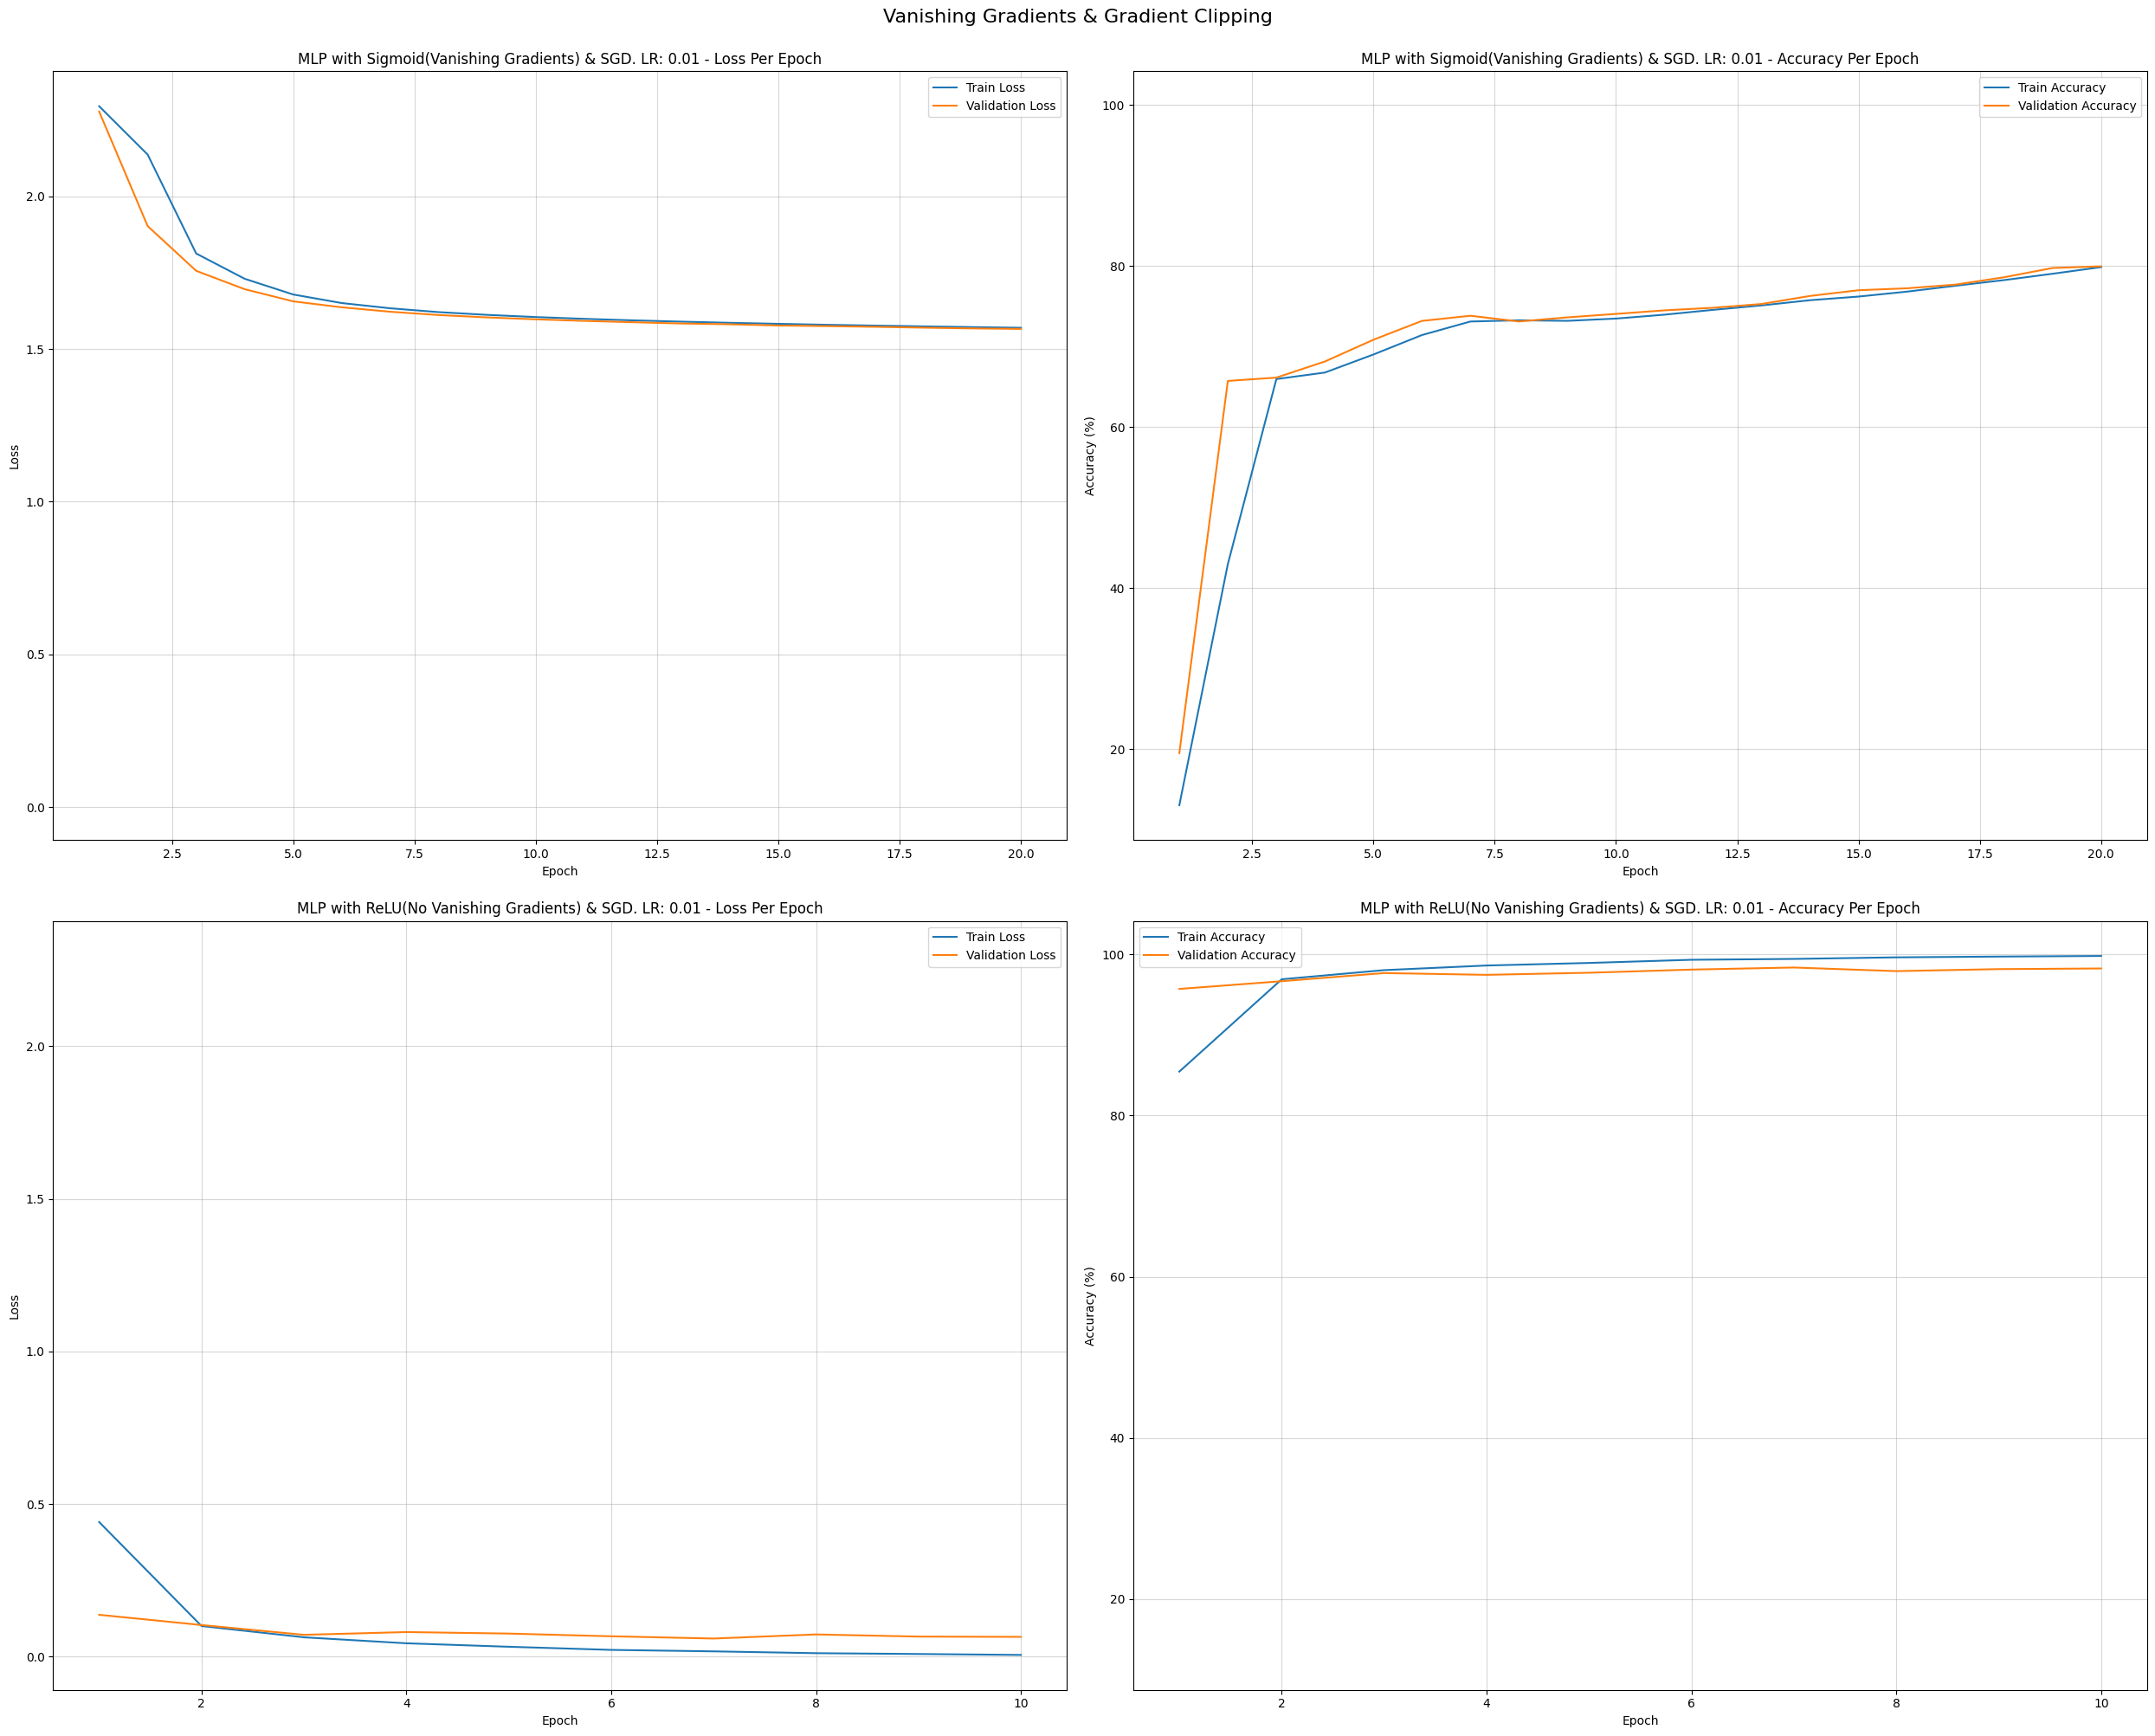

In [10]:
# Create figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(25, 20))

# Data to plot (model metrics)
models_data = [
    (vanishing_grad_model_metrics, f"MLP with Sigmoid(Vanishing Gradients) & SGD. LR: {LEARNING_RATE}"),
    (relu_model_metrics, f"MLP with ReLU(No Vanishing Gradients) & SGD. LR: {LEARNING_RATE}")

]

# Precompute global min and max for loss and accuracy
all_losses = []
all_accuracies = []
for metrics, _ in models_data:
    all_losses.extend(metrics["train_loss_history"])
    all_losses.extend(metrics["val_loss_history"])
    all_accuracies.extend(metrics["train_acc_history"])
    all_accuracies.extend(metrics["val_acc_history"])

# Add 5% padding to the ranges
loss_padding = (max(all_losses) - min(all_losses)) * 0.05
acc_padding = (max(all_accuracies) - min(all_accuracies)) * 0.05

# Set consistent y-axis limits for all plots
for i in range(2):
    # Left column (loss plots)
    axes[i, 0].set_ylim(min(all_losses) - loss_padding, max(all_losses) + loss_padding)

    # Right column (accuracy plots)
    axes[i, 1].set_ylim(min(all_accuracies) - acc_padding, max(all_accuracies) + acc_padding)

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"Vanishing Gradients & Gradient Clipping",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()

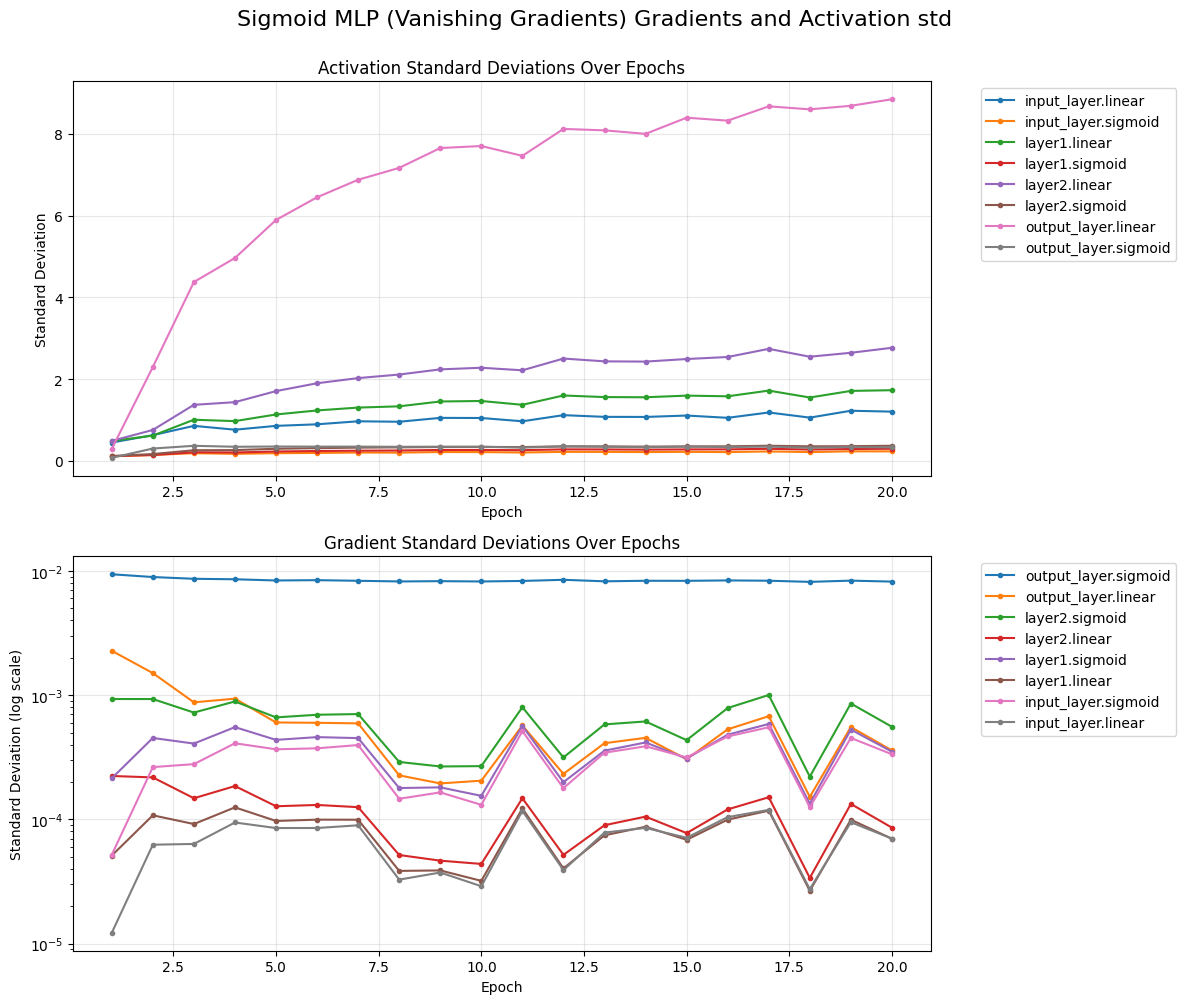

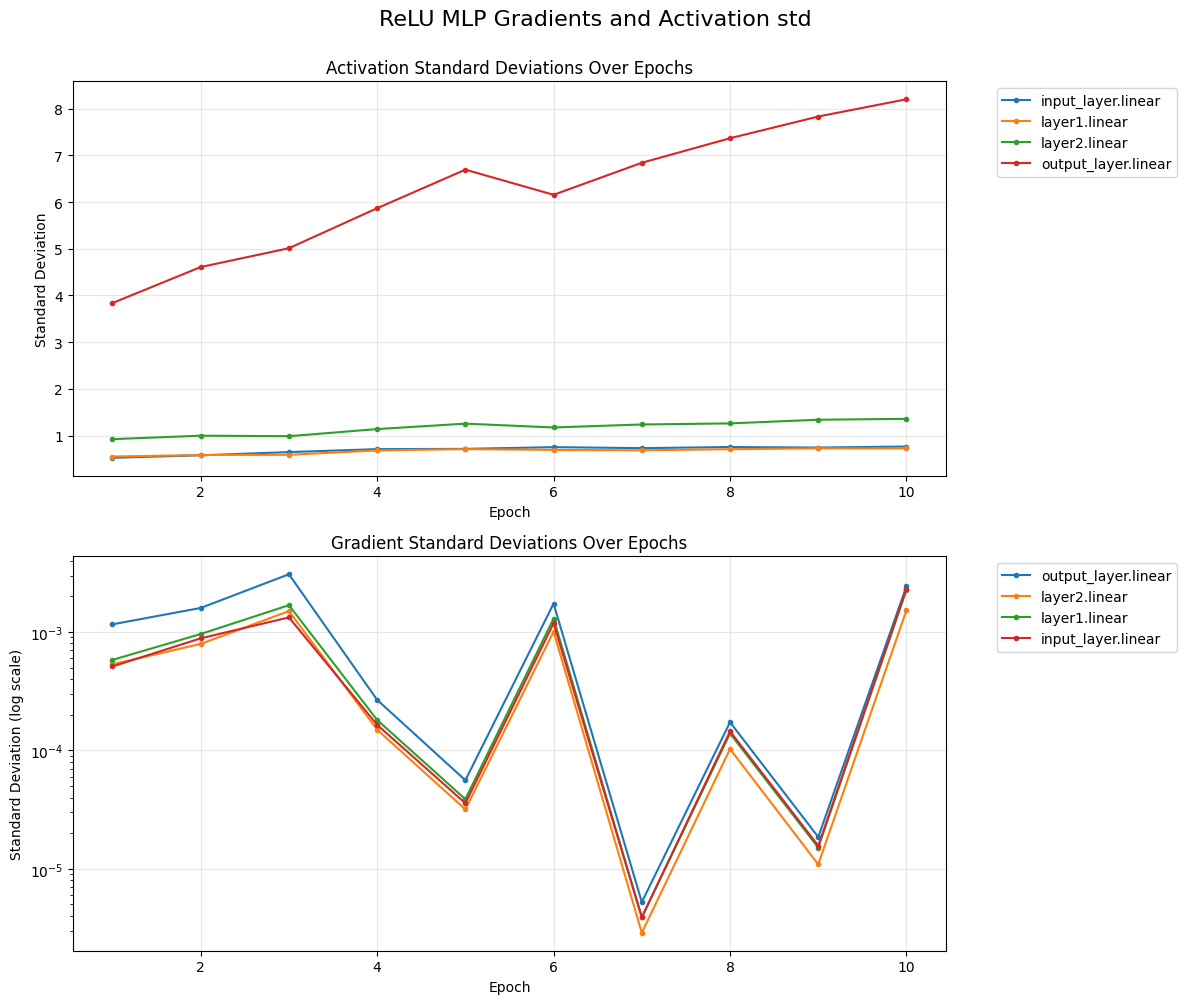

In [11]:
def plot_std_history(activation_std_history, gradient_std_history, model_name):
    """
    Plot activation and gradient standard deviations over epochs for each layer.

    Parameters:
    activation_std_history: List of dictionaries containing activation stds per epoch
    gradient_std_history: List of dictionaries containing gradient stds per epoch
    """
    # Extract layer names from the first epoch
    activation_layers = list(activation_std_history[0].keys())
    gradient_layers = list(gradient_std_history[0].keys())

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot activation standard deviations
    for layer in activation_layers:
        values = [epoch_data[layer] for epoch_data in activation_std_history]
        epochs = range(1, len(values) + 1)
        ax1.plot(epochs, values, label=layer, marker='o', markersize=3)

    ax1.set_title('Activation Standard Deviations Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Standard Deviation')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Plot gradient standard deviations
    for layer in gradient_layers:
        values = [epoch_data[layer] for epoch_data in gradient_std_history]
        epochs = range(1, len(values) + 1)
        ax2.plot(epochs, values, label=layer, marker='o', markersize=3)

    ax2.set_title('Gradient Standard Deviations Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Standard Deviation')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)

    # Use log scale for gradient plot if values vary widely
    if max([max([epoch_data[layer] for epoch_data in gradient_std_history]) for layer in gradient_layers]) / \
       min([min([epoch_data[layer] for epoch_data in gradient_std_history]) for layer in gradient_layers]) > 100:
        ax2.set_yscale('log')
        ax2.set_ylabel('Standard Deviation (log scale)')
    fig.suptitle(f"{model_name} Gradients and Activation std", fontsize= 16, y= 1.0)
    plt.tight_layout()
    plt.show()
    return fig

# Example usage:
fig1= plot_std_history(vanishing_grad_model_metrics["activation_std_history"], vanishing_grad_model_metrics["gradient_std_history"], model_name= "Sigmoid MLP (Vanishing Gradients)")
fig2= plot_std_history(relu_model_metrics["activation_std_history"], relu_model_metrics["gradient_std_history"], model_name= "ReLU MLP")